<a href="https://colab.research.google.com/github/cbsobral/ml-fies/blob/main/Module01_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 03 - WAvg Ensemble



### 1 - Load Data

Here, we import the training and testing sets created in Module00_Data. 


In [1]:
import pandas as pd

url_train = "https://drive.google.com/file/d/1IP7jyXkLgD_Ouy5cL6fJk4VUA5qRB2PK/view?usp=sharing"
path_train = "https://drive.google.com/uc?export=download&id="+url_train.split("/")[-2]
train = pd.read_csv(path_train)
train.shape

(351001, 31)

In [2]:
url_test = "https://drive.google.com/file/d/1v4FqKwt7NzG5RM6d9f1y7CLIdKq69jSS/view?usp=sharing"
path_test = "https://drive.google.com/uc?export=download&id="+url_test.split("/")[-2]
test = pd.read_csv(path_test)
test.shape

(87751, 31)

In [3]:
train_set = train.drop("default", axis=1) # drop targets for training set
train_target = train["default"].copy()

In [4]:
test_set = test.drop("default", axis=1) # drop targets for test set
test_target = test["default"].copy()

### 2 - Pipeline

The pipeline contains functions that will be used to transform the dataset. For the numeric attributes, the stardardization is performed by the StandardScaler. For ordinal attributes, variables are encoded by the OrdinalEncoder, and for categorical, theOneHotEncoder. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([("num_imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler()), 
                         ])

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

ord_pipeline = Pipeline([("ord_imputer", SimpleImputer(strategy="most_frequent")),
                         ("ord_encoder", OrdinalEncoder()),
                         ])

In [7]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

In [8]:
ord_attribs = ["igc","date_contract"] # 2 attributes

num_attribs = ["family_income",   #17
               "personal_income",
               "high_school_endyear",
               "n_sem_course",
               "n_completed_sem",
               "sem_funded",
               "fam_size",
               "income_pc",
               "tuition_current",
               "inc_prop",
               "perc_requested",
               "loan_value_sem",
               "student_resource",
               "loan_value",
               "loan_limit",
               "total_debt",
               "age"]
  

cat_attribs = ["semester_enroll",  #9
               "gender",
               "occupation", 
               "marital_status",
               "ethnicity", 
               "public_hs", 
               "state_course", 
               "degree", 
               "contract_phase"]

In [9]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("ord", ord_pipeline, ord_attribs)
        ])

In [10]:
train_prepared = full_pipeline.fit_transform(train_set)
train_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [11]:
test_prepared = full_pipeline.fit_transform(test_set)
test_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

### 3 - Ensemble Model








Preparing under sampling:

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=42)
data_under, target_under = rus.fit_resample(train_prepared, train_target)



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Random Forest:

In [13]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(bootstrap = False, 
                            criterion = 'entropy', 
                            max_depth = 30, 
                            max_features = 'auto', 
                            min_samples_leaf= 2,
                            min_samples_split = 2,
                            n_estimators = 300,
                            random_state= 42)

ANN:

In [15]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(activation = 'relu',
                    alpha = 0.0001,
                    hidden_layer_sizes = (27, 16),
                    learning_rate = 'adaptive',
                    solver = 'adam', 
                    random_state=42)

Logistic Regression:

In [16]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver = 'liblinear', penalty = 'l1', max_iter= 200, C = 0.1)

### Ensemble model

Our initial idea was to employ weights proportional to the AUC of each model. In this context, Logistic Regression would contribute 0.3; Random forest 0.34; and ANN, 0.36.


In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.3,0.34,0.36],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])





/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [41]:
print(auc_WAvg, loss_WAvg)

0.820519658482 0.1787519176544454


The weights proportional to the AUC resulted in lower performance than the ANN model alone: AUC = 0.8205 , BS = 0.1787

Because of that, we decided to test alternative set of weights.

In the next code blocks we progressevely increased the weight of the ANN to see how the ensemble's performance would react. 

In [16]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.2,0.35,0.45],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])

print(auc_WAvg, loss_WAvg)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8284679308721057 0.17348547312758927


In [17]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.15,0.2,0.65],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])

print(auc_WAvg, loss_WAvg)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8337407552136231 0.1688858388253113


In [45]:
# Best Model:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.05,0.15,0.8],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])

print(auc_WAvg, loss_WAvg)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8354916321533894 0.16666746481378988


In [46]:
import joblib

filename = 'BestWAvg.sav'
joblib.dump(WAvg, filename, compress=3)

['BestWAvg.sav']

In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.05,0.1,0.85],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])

print(auc_WAvg, loss_WAvg)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8352918090809327 0.1664877713156028


In [20]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

WAvg = VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('ANN', MLP)],
        voting='soft', weights=[0.02,0.03,0.95],
        flatten_transform=True)

WAvg.fit(data_under, target_under)

pred_WAvg = WAvg.predict_proba(test_prepared)

auc_WAvg = roc_auc_score(test_target, pred_WAvg[:,1])
loss_WAvg = brier_score_loss(test_target, pred_WAvg[:,1])

print(auc_WAvg, loss_WAvg)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8347659485266183 0.16642469743245566


Evaluating different sets of weights:

In [22]:
import pandas as pd

data = {"weight_LR": [0.05, 0.30, 0.2, 0.15, 0.05, 0.02],
        "weight_RF": [0.15, 0.34, 0.35, 0.2, 0.1, 0.03],
        "weight_ANN": [0.80, 0.36, 0.45, 0.65, 0.85, 0.95],
        "AUC_ensemble":[0.8354,0.8205,0.8284, 0.8337, 0.8352, 0.8347],
        "BS_ensemble":[0.1666,0.1787, 0.1734, 0.1688, 0.1664, 0.1664]}

OptimalWeights = pd.DataFrame(data)
OptimalWeights.sort_values(by = "AUC_ensemble", ascending=False)


,weight_LR,weight_RF,weight_ANN,AUC_ensemble,BS_ensemble
0,0.05,0.15,0.80,0.8354,0.1666
4,0.05,0.10,0.85,0.8352,0.1664
5,0.02,0.03,0.95,0.8347,0.1664
3,0.15,0.20,0.65,0.8337,0.1688
2,0.20,0.35,0.45,0.8284,0.1734
1,0.30,0.34,0.36,0.8205,0.1787


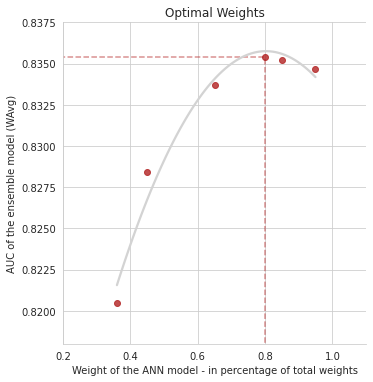

In [47]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl",3)
ax = sns.lmplot(x= "weight_ANN", 
           y= "AUC_ensemble", 
           order = 2, 
           data = OptimalWeights,
           scatter_kws = {"color": 'firebrick'},
           line_kws = {"color": "lightgray"},
           ci=None)
ax.set(ylim=(0.818, 0.8375), xlim=(0.2, 1.1))
ax.set_axis_labels("Weight of the ANN model - in percentage of total weights","AUC of the ensemble model (WAvg)")
plt.title('Optimal Weights')
plt.hlines(y=0.8354, xmin=0, xmax=0.8, color='firebrick', linestyle = "--", alpha =0.5)
plt.vlines(x=0.8, ymin=0, ymax=0.8354, color='firebrick', linestyle = "--", alpha =0.5)

Feature Importance

In [17]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [19]:
import warnings
import sklearn
import pandas as pd
feature_names = get_feature_names(full_pipeline)
feature_names

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Transformer num_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Transformer ord_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Transformer ord_encoder (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available


['num__family_income',
 'num__personal_income',
 'num__high_school_endyear',
 'num__n_sem_course',
 'num__n_completed_sem',
 'num__sem_funded',
 'num__fam_size',
 'num__income_pc',
 'num__tuition_current',
 'num__inc_prop',
 'num__perc_requested',
 'num__loan_value_sem',
 'num__student_resource',
 'num__loan_value',
 'num__loan_limit',
 'num__total_debt',
 'num__age',
 'one_hot__x0_12012',
 'one_hot__x0_12013',
 'one_hot__x0_12014',
 'one_hot__x0_22012',
 'one_hot__x0_22013',
 'one_hot__x0_22014',
 'one_hot__x0_before 2012',
 'one_hot__x1_F',
 'one_hot__x1_M',
 'one_hot__x2_Estudante',
 'one_hot__x2_OUTRAS',
 'one_hot__x3_Casado',
 'one_hot__x3_Divorciado',
 'one_hot__x3_Separado',
 'one_hot__x3_Solteiro',
 'one_hot__x3_UniÃ£o estÃ¡vel',
 'one_hot__x3_ViÃºvo',
 'one_hot__x4_A',
 'one_hot__x4_B',
 'one_hot__x4_I',
 'one_hot__x4_N',
 'one_hot__x4_P',
 'one_hot__x5_N',
 'one_hot__x5_P',
 'one_hot__x5_S',
 'one_hot__x6_AC',
 'one_hot__x6_AL',
 'one_hot__x6_AM',
 'one_hot__x6_AP',
 'one_hot

In [20]:
pip install eli5

     |████████████████████████████████| 112kB 14.1MB/s 


In [22]:
import joblib

WAvg = joblib.load('BestWAvg.sav')

In [23]:
import eli5
from eli5.sklearn import PermutationImportance


# convert to dense array
test_prep_dense = test_prepared.toarray()

perm = PermutationImportance(WAvg, random_state=42).fit(test_prep_dense, test_target)

eli5.show_weights(perm, feature_names = feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1504 ± 0.0018,num__total_debt
0.0916 ± 0.0017,num__n_completed_sem
0.0904 ± 0.0020,num__loan_limit
0.0890 ± 0.0017,num__sem_funded
0.0876 ± 0.0010,num__loan_value
0.0637 ± 0.0021,num__n_sem_course
0.0295 ± 0.0013,one_hot__x0_12014
0.0254 ± 0.0012,one_hot__x0_22014
0.0248 ± 0.0016,num__loan_value_sem
0.0241 ± 0.0011,one_hot__x0_12012


In [24]:
import joblib

filename = 'FeatureImportance.sav'
joblib.dump(perm, filename, compress=3)

['FeatureImportance.sav']

Text(0.5, 1.0, '10 most important features')

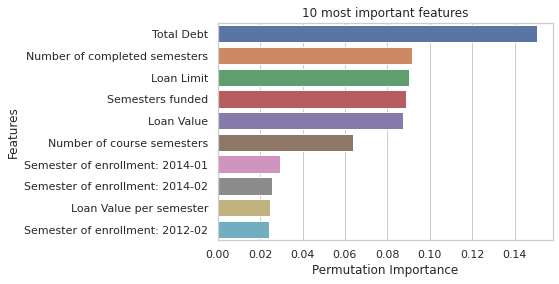

In [75]:
import seaborn as seaborn

importance_f = eli5.explain_weights_df(perm, feature_names=feature_names).head(10)

importance_f["New_names"] = ["Total Debt", 
                             "Number of completed semesters",
                             "Loan Limit",
                             "Semesters funded",
                             "Loan Value",
                             "Number of course semesters",
                             "Semester of enrollment: 2014-01",
                             "Semester of enrollment: 2014-02",
                             "Loan Value per semester",
                             "Semester of enrollment: 2012-02"]

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="weight", y="New_names", data=importance_f)
ax.set_ylabel("Features")
ax.set_xlabel("Permutation Importance")
ax.set_title('10 most important features')
